## **Object Detection using YOLOv8 – End-to-End Pipeline**

**Introduction**

Object detection is a key task in computer vision that allows us to locate and classify multiple objects within an image. In this project, the goal was to work with a Kaggle dataset containing cows and buffaloes, and build a pipeline that detects and classifies these animals.

We use Convolutional Neural Networks (CNNs), which are the backbone of most modern computer vision models. Specifically, we employ YOLOv8 (You Only Look Once, version 8) — a state-of-the-art CNN-based object detection architecture.

The purpose of this experiment is to:

1. Understand the complete workflow of training an object detection model.

2. Compare the performance of different YOLOv8 variants (small, medium, large).

3. Learn how dataset size, quality, and model complexity affect results.

**Problem Statement**

Given a dataset of cow images with annotated bounding boxes, we want to:

1. Train a YOLOv8 model to detect and classify the objects.

2. Evaluate multiple YOLOv8 model variants.

3. Identify the best-performing model for our dataset.

**Objectives**

1. Preprocess and prepare the dataset in YOLO format (images + labels).

2. Configure a data.yaml file for training.

3. Train multiple YOLOv8 models (YOLOv8s, YOLOv8m, YOLOv8l).

4. Evaluate the models using metrics like Precision, Recall, mAP50, and mAP50-95.

5. Visualize predictions vs. ground truth.

6. Summarize results and conclude which model works best.

**Technologies Used**

1. **CNN (Convolutional Neural Networks) **→ The foundation of YOLOv8.

2. **YOLOv8 (Ultralytics)** → Advanced object detection framework built on CNNs.

3.** Transfer Learning** → Leveraging pre-trained YOLO weights (yolov8n.pt, yolov8s.pt, etc.).

4. **Data Augmentation **→ Built-in YOLO augmentations during training.

5. **Optimization** → GPU acceleration (Tesla T4 in Colab), learning rate scheduling.

6. **Tools & Libraries** → PyTorch, TensorFlow (optional background), OpenCV, Matplotlib, Ultralytics YOLO.

# **Steps Followed**

**a) Dataset Preparation**

1. Mounted Google Drive and loaded dataset.

2. Verified images and labels were correctly paired.

3. Handled mismatches (images without labels or vice versa).

4. Created a train/validation split (85% train, 15% val).

5. Wrote a data.yaml file specifying:
Dataset path, Train/val directories, Number of classes (nc), Class names

b) **Installing Dependencies**

1. Installed Ultralytics YOLOv8 library

2. Installed additional tools: OpenCV, matplotlib, pycocotools

**c) Model Training**

We trained three variants of YOLOv8:

1. YOLOv8s (small) – faster, lightweight, suitable for small datasets

2. YOLOv8m (medium) – balance between speed and accuracy

3. YOLOv8l (large) – deeper and heavier, needs more data and GPU power

**Training hyperparameters:**

1. Epochs: 10–25

2. Image size: 416–640

3. Batch size: 8–16 (adjusted to GPU memory)

**d) Model Evaluation**

For each trained model, we checked:

1. Precision (P) – how many predicted boxes were correct.

2. Recall (R) – how many ground-truth boxes were detected.

3. mAP50 – mean average precision at IoU=0.5.

4. mAP50-95 – stricter metric, more reliable for comparison.

**e) Visualization**

1. Plotted ground truth boxes (green) and predictions (red).

2. Compared predictions from YOLOv8s, YOLOv8m, and YOLOv8l side by side.

## **Models Used**

**a) YOLOv8s (Small)**

1. Best suited for real-time inference

2. Lower computational cost

3. Best performance in this dataset

**b) YOLOv8m (Medium)**

1. Balanced, larger capacity than small

2. Slightly worse recall compared to s

**c) YOLOv8l (Large)**

1. Needs more training data and GPU power

2. Performed poorly due to dataset constraints

**Cell 1 — Mounting Drive & imports**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, pathlib, shutil, random, sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
print("Drive mounted and libs loaded.")


Mounted at /content/drive
Drive mounted and libs loaded.


**Cell 2 — Setting the Drive dataset paths & workspace**

In [2]:
IMG_DIR = "/content/drive/MyDrive/train/images"
LBL_DIR = "/content/drive/MyDrive/train/labels"

# workspace where we prepare data & store results
WORK_DIR = "/content/detection_workspace"
DATA_DIR = os.path.join(WORK_DIR, "data")
os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

print("IMG_DIR exists:", os.path.exists(IMG_DIR))
print("LBL_DIR exists:", os.path.exists(LBL_DIR))
print("WORK_DIR:", WORK_DIR)


IMG_DIR exists: True
LBL_DIR exists: True
WORK_DIR: /content/detection_workspace


**Cell 3 — Sanity check filenames & report mismatches**

In [3]:
# list images and label bases
img_exts = {".jpg", ".jpeg", ".png", ".bmp"}
images = [f for f in os.listdir(IMG_DIR) if pathlib.Path(f).suffix.lower() in img_exts]
labels = [f for f in os.listdir(LBL_DIR) if f.endswith(".txt")]

img_bases = {pathlib.Path(f).stem for f in images}
lbl_bases = {pathlib.Path(f).stem for f in labels}

only_imgs = sorted(list(img_bases - lbl_bases))
only_lbls = sorted(list(lbl_bases - img_bases))
common_bases = sorted(list(img_bases & lbl_bases))

print(f"Total images: {len(images)}, total label-files: {len(labels)}")
print(f"Paired (image+label): {len(common_bases)}")
print(f"Images without labels: {len(only_imgs)} (sample -> {only_imgs[:5]})")
print(f"Labels without images: {len(only_lbls)} (sample -> {only_lbls[:5]})")

# If many mismatches, try simple filename normalization helper
if len(only_imgs) > 0 or len(only_lbls) > 0:
    print("\nIf mismatch is due to casing or spaces, you can run the optional normalizer cell (next).")


Total images: 1747, total label-files: 1747
Paired (image+label): 1747
Images without labels: 0 (sample -> [])
Labels without images: 0 (sample -> [])


**Cell 4 — Normalizing filenames: lowercase & replace spaces — run only if you have mismatches**

In [4]:
def normalize_filenames(folder):
    for fname in os.listdir(folder):
        src = os.path.join(folder, fname)
        newname = fname.strip().lower().replace(" ", "_")
        dst = os.path.join(folder, newname)
        if src != dst:
            try:
                os.rename(src, dst)
            except Exception as e:
                pass



**Cell 5 — Prepare YOLO folder structure and copy paired files (train/val split)**

In [5]:
# Prepare data/images/{train,val} and data/labels/{train,val}
random.seed(42)

images = [f for f in os.listdir(IMG_DIR) if pathlib.Path(f).suffix.lower() in img_exts]
labels = [f for f in os.listdir(LBL_DIR) if f.endswith(".txt")]
img_bases = {pathlib.Path(f).stem for f in images}
lbl_bases = {pathlib.Path(f).stem for f in labels}
common_bases = sorted(list(img_bases & lbl_bases))

if len(common_bases) == 0:
    raise SystemExit("No matching image+label pairs found. Check IMG_DIR and LBL_DIR and run the normalizer if needed.")

# train/val split
val_frac = 0.15
random.shuffle(common_bases)
n = len(common_bases)
n_val = max(1, int(val_frac * n))
val_bases = common_bases[:n_val]
train_bases = common_bases[n_val:]
print("Train samples:", len(train_bases), "Val samples:", len(val_bases))

# Create directories
train_img_dir = os.path.join(DATA_DIR, "images", "train")
train_lbl_dir = os.path.join(DATA_DIR, "labels", "train")
val_img_dir   = os.path.join(DATA_DIR, "images", "val")
val_lbl_dir   = os.path.join(DATA_DIR, "labels", "val")
for d in [train_img_dir, train_lbl_dir, val_img_dir, val_lbl_dir]:
    os.makedirs(d, exist_ok=True)

# helper to find the real image file with any supported extension
def find_image_file(base):
    for ext in img_exts:
        cand = os.path.join(IMG_DIR, base + ext)
        if os.path.exists(cand):
            return cand
    return None

copied_train, copied_val = 0, 0
for base in train_bases:
    ip = find_image_file(base)
    lp = os.path.join(LBL_DIR, base + ".txt")
    if ip and os.path.exists(lp):
        shutil.copy(ip, os.path.join(train_img_dir, os.path.basename(ip)))
        shutil.copy(lp, os.path.join(train_lbl_dir, os.path.basename(lp)))
        copied_train += 1

for base in val_bases:
    ip = find_image_file(base)
    lp = os.path.join(LBL_DIR, base + ".txt")
    if ip and os.path.exists(lp):
        shutil.copy(ip, os.path.join(val_img_dir, os.path.basename(ip)))
        shutil.copy(lp, os.path.join(val_lbl_dir, os.path.basename(lp)))
        copied_val += 1

print("Copied train images:", copied_train, "val images:", copied_val)
print("Prepared YOLO dataset at:", DATA_DIR)
!find /content/detection_workspace/data -maxdepth 3 -type f | sed -n '1,20p'


Train samples: 1485 Val samples: 262
Copied train images: 1485 val images: 262
Prepared YOLO dataset at: /content/detection_workspace/data
/content/detection_workspace/data/images/train/hf02-195_jpeg_jpg.rf.0e6dd4071094dddcc8a63f75277dcf92.jpg
/content/detection_workspace/data/images/train/hf01-14_jpeg_jpg.rf.8a62f2485bfaeb31aa34eed812991bf8.jpg
/content/detection_workspace/data/images/train/img00451_jpg.rf.3ea44216c1dd2d1e889fd69721d9ac40.jpg
/content/detection_workspace/data/images/train/Ayrshirecattle43_c_jpg.rf.9e98a7c67e9f60296781c1764b9cd0b5.jpg
/content/detection_workspace/data/images/train/cows-in-pasture-mating-WFBWPJ_jpeg_jpg.rf.ee3c8ee358707b4e270ef7a4121f589e.jpg
/content/detection_workspace/data/images/train/hf02-14_jpeg_jpg.rf.81af84437e1aa19613ef9bde3147135d.jpg
/content/detection_workspace/data/images/train/vaca235_jpg.rf.12fd135c8e225bdd90a58479bce9f06e.jpg
/content/detection_workspace/data/images/train/hf02-110_jpeg_jpg.rf.8098d54aab7a5220c0706afe37e5cd0d.jpg
/content

**Cell 6 — Inspect label contents & infer classes**

In [6]:
# Inspecting label files to see which class IDs exist
classes_present = set()
for sub in ["train", "val"]:
    labdir = os.path.join(DATA_DIR, "labels", sub)
    if not os.path.exists(labdir): continue
    for fname in os.listdir(labdir)[:500]:
        with open(os.path.join(labdir, fname), "r") as fh:
            for line in fh:
                parts = line.strip().split()
                if len(parts) >= 1:
                    classes_present.add(parts[0])
print("Class ids found:", classes_present)

# Print a few label file examples
print("\nExample train label files (first 5):")
labdir = os.path.join(DATA_DIR, "labels", "train")
for i, fname in enumerate(sorted(os.listdir(labdir))[:5]):
    print("----", fname, "----")
    print(open(os.path.join(labdir, fname)).read().strip())
    print()


Class ids found: {'5', '4', '1', '8', '2', '11', '6', '3', '0', '7'}

Example train label files (first 5):
---- -OWS_mp4-105_jpg.rf.12f35a8f4cb7c44f77778c850c8ad960.txt ----
0 0.3734375 0.55546875 0.4234375 0.6453125

---- -OWS_mp4-123_jpg.rf.cbbeabac2f865791829c2fb8adfdafe5.txt ----
0 0.3234375 0.421875 0.1015625 0.346875
0 0.5859375 0.53203125 0.2828125 0.575
0 0.1359375 0.584375 0.271875 0.525

---- -OWS_mp4-125_jpg.rf.1fc743df861b0674172fb10c419396e7.txt ----
0 0.46875 0.528125 0.18125 0.76875
0 0.7140625 0.53984375 0.315625 0.784375
0 0.2984375 0.55078125 0.19375 0.7515625

---- -OWS_mp4-13_jpg.rf.6526f1c63f4c1eede8ad8e5ea555777f.txt ----
8 0.625 0.2625 0.0453125 0.0671875
8 0.703125 0.275 0.05625 0.0921875
8 0.746875 0.32265625 0.0515625 0.1296875
8 0.896875 0.4515625 0.165625 0.35625
8 0.63125 0.58125 0.265625 0.6078125
8 0.3078125 0.64375 0.615625 0.6984375
8 0.81796875 0.32265625 0.0796875 0.159375

---- -OWS_mp4-140_jpg.rf.e43d9e6aae392368b819196fe09fca44.txt ----
0 0.5835937

**Cell 7 — Converting to single-class detector for cows only**

In [7]:
COW_CLASS_ID = 0

def convert_to_single_class(lbl_folder, img_folder, cow_class_id):
    removed = 0
    for fname in os.listdir(lbl_folder):
        p = os.path.join(lbl_folder, fname)
        with open(p, "r") as fh:
            lines = fh.readlines()
        new_lines = []
        for L in lines:
            parts = L.strip().split()
            if len(parts) < 5:
                continue
            cls = int(float(parts[0]))
            if cls == cow_class_id:
                # write as class 0 (single class)
                new_lines.append(" ".join(["0"] + parts[1:]) + "\n")
        if new_lines:
            with open(p, "w") as fh:
                fh.writelines(new_lines)
        else:
            # remove label and corresponding image
            os.remove(p)
            base = fname.replace(".txt","")
            for ext in img_exts:
                ip = os.path.join(img_folder, base + ext)
                if os.path.exists(ip):
                    os.remove(ip)
            removed += 1
    return removed



**Cell 8 — Create data.yaml (for YOLOv8)**

In [8]:
import yaml

# Infer classes remaining
classes_now = set()
for sub in ["train","val"]:
    labdir = os.path.join(DATA_DIR, "labels", sub)
    if not os.path.exists(labdir): continue
    for fname in os.listdir(labdir):
        for line in open(os.path.join(labdir, fname)):
            parts = line.strip().split()
            if len(parts) >= 1:
                classes_now.add(parts[0])

if classes_now == {"0"} or classes_now == set():
    nc = 1
    names = ["cow"]
else:
    unique_ints = sorted({int(x) for x in classes_now})
    nc = max(unique_ints) + 1
    names = [f"class_{i}" for i in range(nc)]

data_yaml = {
    "path": DATA_DIR,
    "train": "images/train",
    "val": "images/val",
    "nc": nc,
    "names": names
}

YAML_PATH = os.path.join(WORK_DIR, "data.yaml")
with open(YAML_PATH, "w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print("Wrote data.yaml:")
print(open(YAML_PATH).read())


Wrote data.yaml:
path: /content/detection_workspace/data
train: images/train
val: images/val
nc: 12
names:
- class_0
- class_1
- class_2
- class_3
- class_4
- class_5
- class_6
- class_7
- class_8
- class_9
- class_10
- class_11



**Cell 9 — Install YOLOv8 (Ultralytics) and deps**

In [9]:
# run as a code cell (bash)
!pip -q install ultralytics
!pip -q install --upgrade --no-deps opencv-python-headless matplotlib pycocotools


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 69.7 MB/s eta 0:00:00


In [10]:

from ultralytics import YOLO
print("Ultralytics version loaded.")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics version loaded.


**Cell 10 — Train YOLOv8 (transfer learning)**

In [12]:
from ultralytics import YOLO

# Choosing a pre-trained model: yolov8n.pt (nano) is fast for prototyping.
model = YOLO("yolov8n.pt")


res = model.train(
    data=YAML_PATH,
    epochs=10,
    imgsz=416,
    batch=8,
    project=WORK_DIR,
    name="yolov8_cow_experiment_fast",
    exist_ok=True,
    device=0
)

print("Training finished. Result:", res)


Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/detection_workspace/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_cow_experiment_fast, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspecti

**Cell 11 — Save best weights to Drive & evaluate**

In [19]:
# matching the experiment name from training
exp_dir = os.path.join(WORK_DIR, "yolov8_cow_experiment_fast")
best_weights = os.path.join(exp_dir, "weights", "best.pt")
print("Best weights path:", best_weights, "exists:", os.path.exists(best_weights))

# copy to Drive
dst = "/content/drive/MyDrive/yolov8_best_cow.pt"
if os.path.exists(best_weights):
    shutil.copy(best_weights, dst)
    print("Copied best weights to Drive:", dst)
else:
    print("Best weights not found. Check training logs.")

# Evaluating using best weights
if os.path.exists(best_weights):
    model = YOLO(best_weights)
    metrics = model.val(data=YAML_PATH, imgsz=416, conf=0.25)
    print("Validation metrics:", metrics)


Best weights path: /content/detection_workspace/yolov8_cow_experiment_fast/weights/best.pt exists: True
Copied best weights to Drive: /content/drive/MyDrive/yolov8_best_cow.pt
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1963.4±451.5 MB/s, size: 59.9 KB)
val: Scanning /content/detection_workspace/data/labels/val.cache... 262 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 262/262 485.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 5.4it/s 3.2s
                   all        262        703      0.362      0.397      0.383      0.314
               class_0        120        467      0.775      0.863      0.892      0.719
               class_1          2          5          0          0          0          0
               class_2         48  

**Cell 12 — Inference & visualization (predictions vs GT)**




image 1/1 /content/detection_workspace/data/images/val/-OWS_mp4-156_jpg.rf.1f0d7a29d5d7cfa8fa43b0e9185763d2.jpg: 640x640 2 class_0s, 1 class_8, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/detection_workspace/data/images/val/-OWS_mp4-239_jpg.rf.63ad3894bc13a7c893f8a1bcdecc7d9e.jpg: 640x640 1 class_0, 7.3ms
Speed: 1.5ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/detection_workspace/data/images/val/-OWS_mp4-321_jpg.rf.c6b997bbc257dbbedba9eaf315f8d765.jpg: 640x640 1 class_8, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/detection_workspace/data/images/val/-OWS_mp4-36_jpg.rf.bd1b0d98c20247b68756f24925dc2616.jpg: 640x640 2 class_0s, 1 class_8, 7.3ms
Speed: 1.5ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/detection_workspa

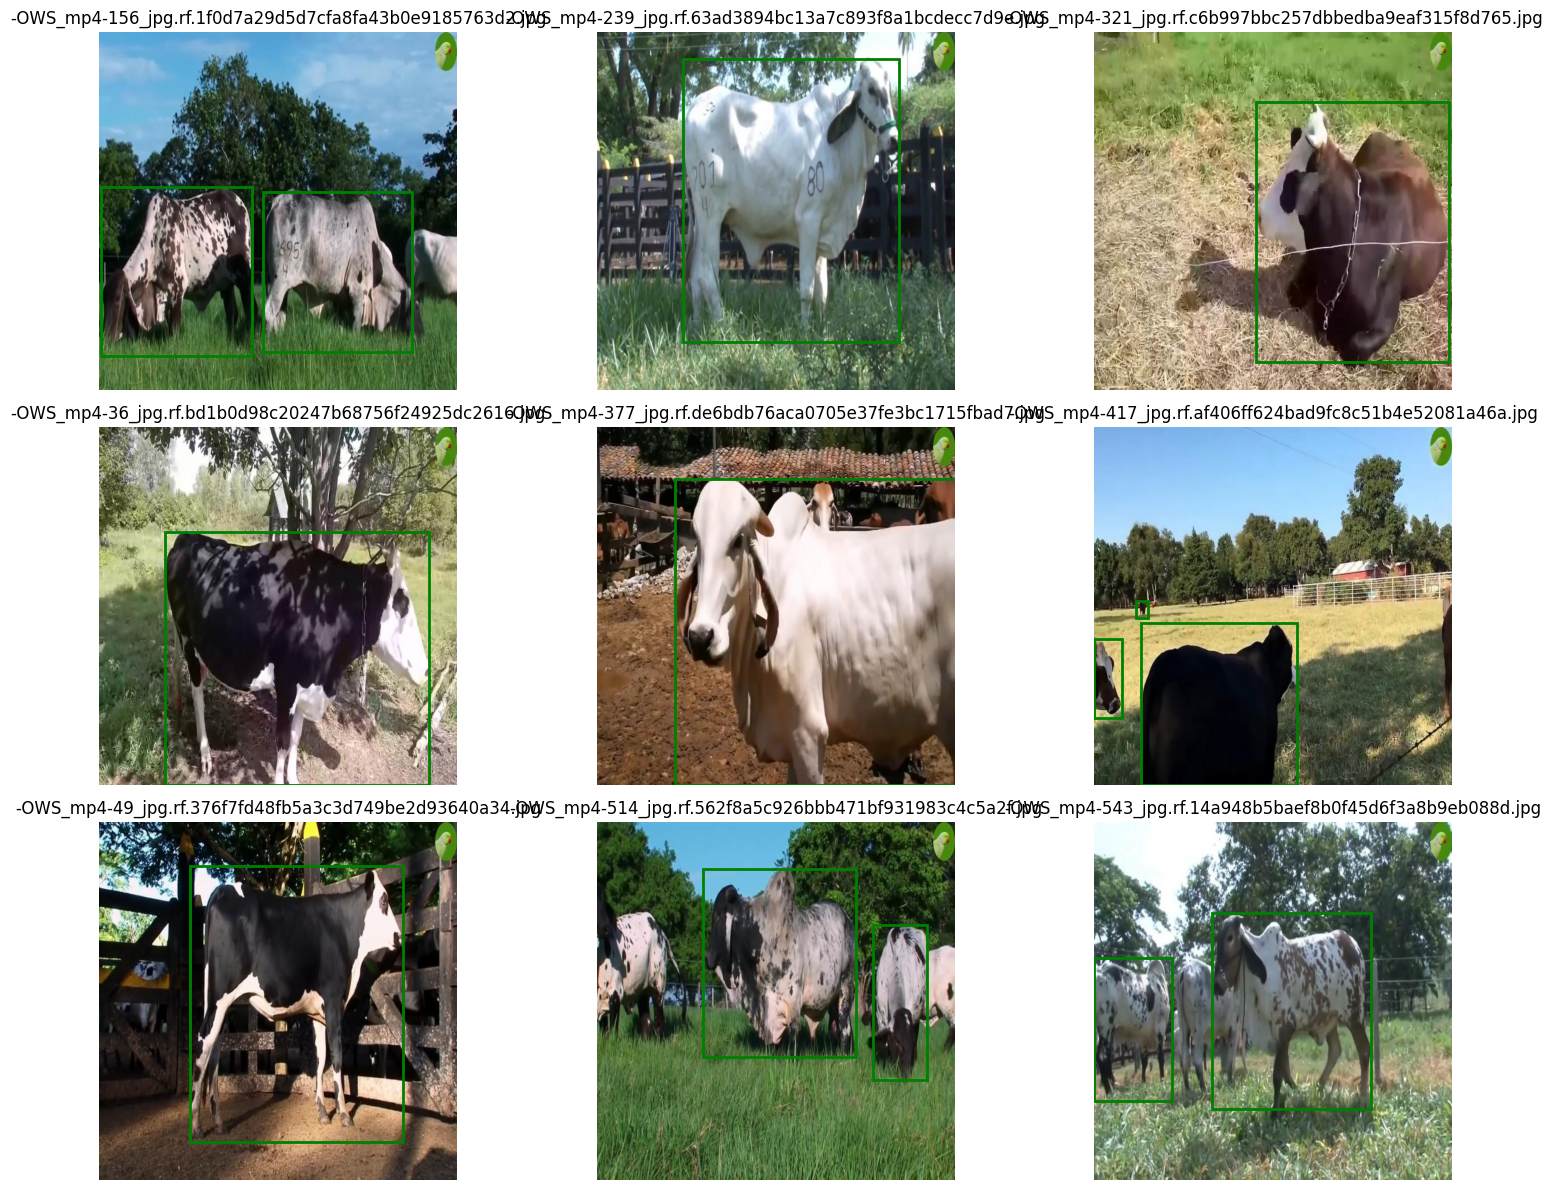

In [15]:
from ultralytics import YOLO
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pathlib

# load model (best weights)
model = YOLO(best_weights)

def load_yolo_labels(lbl_path):
    boxes = []
    if not os.path.exists(lbl_path):
        return []
    with open(lbl_path, 'r') as fh:
        for line in fh:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, xc, yc, w, h = parts
            boxes.append((int(float(cls)), float(xc), float(yc), float(w), float(h)))
    return boxes

def yolo_to_bbox(box, img_w, img_h):
    _, xc, yc, w, h = box
    x1 = int((xc - w/2) * img_w)
    y1 = int((yc - h/2) * img_h)
    x2 = int((xc + w/2) * img_w)
    y2 = int((yc + h/2) * img_h)
    return [x1,y1,x2,y2]

val_img_dir = os.path.join(DATA_DIR, "images", "val")
val_lbl_dir = os.path.join(DATA_DIR, "labels", "val")
val_imgs = sorted(os.listdir(val_img_dir))[:12]

plt.figure(figsize=(16,12))
for i, fname in enumerate(val_imgs[:9]):
    img_path_local = os.path.join(val_img_dir, fname)
    img = cv2.imread(img_path_local)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h,w = img.shape[:2]

    # GT
    lblfile = os.path.join(val_lbl_dir, pathlib.Path(fname).stem + ".txt")
    gt_boxes = load_yolo_labels(lblfile)
    gt_pixels = [yolo_to_bbox(b, w, h) for b in gt_boxes]

    # Predictions
    preds = model.predict(img_path_local, imgsz=640, conf=0.25)[0]
    boxes_pred = []
    try:
        for box in preds.boxes.cpu().numpy():
            x1,y1,x2,y2,conf,cls = box
            boxes_pred.append((int(x1),int(y1),int(x2),int(y2),float(conf),int(cls)))
    except:
        boxes_pred = []

    ax = plt.subplot(3,3,i+1)
    ax.imshow(img_rgb)
    # draw GT in green
    for b in gt_pixels:
        x1,y1,x2,y2 = b
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
    # draw preds in red
    for (x1,y1,x2,y2,conf,cls) in boxes_pred:
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, max(y1-5,0), f"{cls}:{conf:.2f}", color='r', fontsize=9, backgroundcolor='white')
    ax.axis('off')
    ax.set_title(fname)
plt.tight_layout()
plt.show()


**Cell 12 - Train YOLOv8s (small)**

In [16]:
from ultralytics import YOLO
import os, shutil

# Load small model
model_s = YOLO("yolov8s.pt")

# Train
res_s = model_s.train(
    data=YAML_PATH,
    epochs=10,
    imgsz=416,
    batch=8,
    project=WORK_DIR,
    name="yolov8_cow_experiment_s",
    exist_ok=True
)
print("YOLOv8s training finished.")

# Save best weights to Drive
best_weights_s = os.path.join(WORK_DIR, "yolov8_cow_experiment_s", "weights", "best.pt")
dst_s = "/content/drive/MyDrive/yolov8_best_cow_s.pt"
if os.path.exists(best_weights_s):
    shutil.copy(best_weights_s, dst_s)
    print("Copied YOLOv8s best weights to:", dst_s)


Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/detection_workspace/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_cow_experiment_s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=

**Cell 13 - Train YOLOv8m (medium)**

In [17]:
# Load medium model
model_m = YOLO("yolov8m.pt")

# Train
res_m = model_m.train(
    data=YAML_PATH,
    epochs=10,
    imgsz=416,
    batch=8,
    project=WORK_DIR,
    name="yolov8_cow_experiment_m",
    exist_ok=True
)
print("YOLOv8m training finished.")

# Save best weights to Drive
best_weights_m = os.path.join(WORK_DIR, "yolov8_cow_experiment_m", "weights", "best.pt")
dst_m = "/content/drive/MyDrive/yolov8_best_cow_m.pt"
if os.path.exists(best_weights_m):
    shutil.copy(best_weights_m, dst_m)
    print("Copied YOLOv8m best weights to:", dst_m)


Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/detection_workspace/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_cow_experiment_m, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=

**Cell 13 - Train YOLOv8l (large)**


In [18]:
# Load large model
model_l = YOLO("yolov8l.pt")

# Train
res_l = model_l.train(
    data=YAML_PATH,
    epochs=10,
    imgsz=416,
    batch=4,   # reduce batch for large model
    project=WORK_DIR,
    name="yolov8_cow_experiment_l",
    exist_ok=True
)
print("YOLOv8l training finished.")

# Save best weights to Drive
best_weights_l = os.path.join(WORK_DIR, "yolov8_cow_experiment_l", "weights", "best.pt")
dst_l = "/content/drive/MyDrive/yolov8_best_cow_l.pt"
if os.path.exists(best_weights_l):
    shutil.copy(best_weights_l, dst_l)
    print("Copied YOLOv8l best weights to:", dst_l)


Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/detection_workspace/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_cow_experiment_l, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=

**Comparing Models (YOLOv8n, s, m, l)**

In [21]:
def plot_preds(models_dict, img_path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(16, 4 * len(models_dict)))
    for i, (name, model) in enumerate(models_dict.items()):
        preds = model.predict(img_path, imgsz=640, conf=0.25)[0]

        ax = plt.subplot(len(models_dict), 1, i+1)
        ax.imshow(img_rgb)

        # Correct way to iterate predictions
        for box in preds.boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            conf = float(box.conf[0])
            cls = int(box.cls[0])

            rect = patches.Rectangle(
                (int(x1), int(y1)),
                int(x2-x1), int(y2-y1),
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(int(x1), max(int(y1)-5,0), f"{cls}:{conf:.2f}",
                    color='r', fontsize=9, backgroundcolor='white')

        ax.set_title(f"{name} predictions")
        ax.axis('off')

    plt.tight_layout()
    plt.show()



Comparing predictions on: -OWS_mp4-156_jpg.rf.1f0d7a29d5d7cfa8fa43b0e9185763d2.jpg

image 1/1 /content/detection_workspace/data/images/val/-OWS_mp4-156_jpg.rf.1f0d7a29d5d7cfa8fa43b0e9185763d2.jpg: 640x640 2 class_0s, 1 class_8, 16.5ms
Speed: 2.4ms preprocess, 16.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/detection_workspace/data/images/val/-OWS_mp4-156_jpg.rf.1f0d7a29d5d7cfa8fa43b0e9185763d2.jpg: 640x640 2 class_0s, 1 class_8, 37.0ms
Speed: 1.7ms preprocess, 37.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/detection_workspace/data/images/val/-OWS_mp4-156_jpg.rf.1f0d7a29d5d7cfa8fa43b0e9185763d2.jpg: 640x640 2 class_0s, 1 class_8, 62.6ms
Speed: 1.6ms preprocess, 62.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


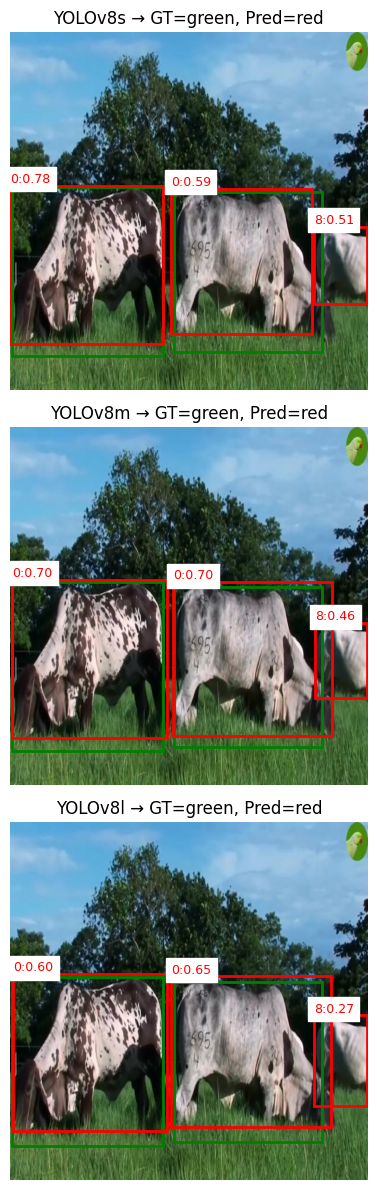


Comparing predictions on: -OWS_mp4-239_jpg.rf.63ad3894bc13a7c893f8a1bcdecc7d9e.jpg

image 1/1 /content/detection_workspace/data/images/val/-OWS_mp4-239_jpg.rf.63ad3894bc13a7c893f8a1bcdecc7d9e.jpg: 640x640 1 class_8, 16.3ms
Speed: 2.4ms preprocess, 16.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/detection_workspace/data/images/val/-OWS_mp4-239_jpg.rf.63ad3894bc13a7c893f8a1bcdecc7d9e.jpg: 640x640 1 class_8, 24.3ms
Speed: 2.2ms preprocess, 24.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/detection_workspace/data/images/val/-OWS_mp4-239_jpg.rf.63ad3894bc13a7c893f8a1bcdecc7d9e.jpg: 640x640 1 class_2, 41.1ms
Speed: 2.1ms preprocess, 41.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


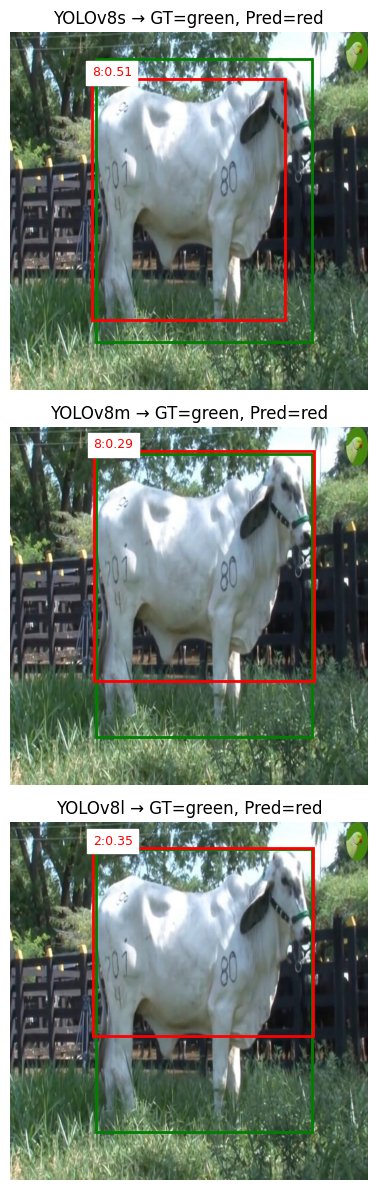


Comparing predictions on: -OWS_mp4-321_jpg.rf.c6b997bbc257dbbedba9eaf315f8d765.jpg

image 1/1 /content/detection_workspace/data/images/val/-OWS_mp4-321_jpg.rf.c6b997bbc257dbbedba9eaf315f8d765.jpg: 640x640 1 class_8, 11.0ms
Speed: 6.0ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/detection_workspace/data/images/val/-OWS_mp4-321_jpg.rf.c6b997bbc257dbbedba9eaf315f8d765.jpg: 640x640 1 class_2, 24.3ms
Speed: 2.1ms preprocess, 24.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/detection_workspace/data/images/val/-OWS_mp4-321_jpg.rf.c6b997bbc257dbbedba9eaf315f8d765.jpg: 640x640 1 class_0, 41.2ms
Speed: 2.0ms preprocess, 41.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


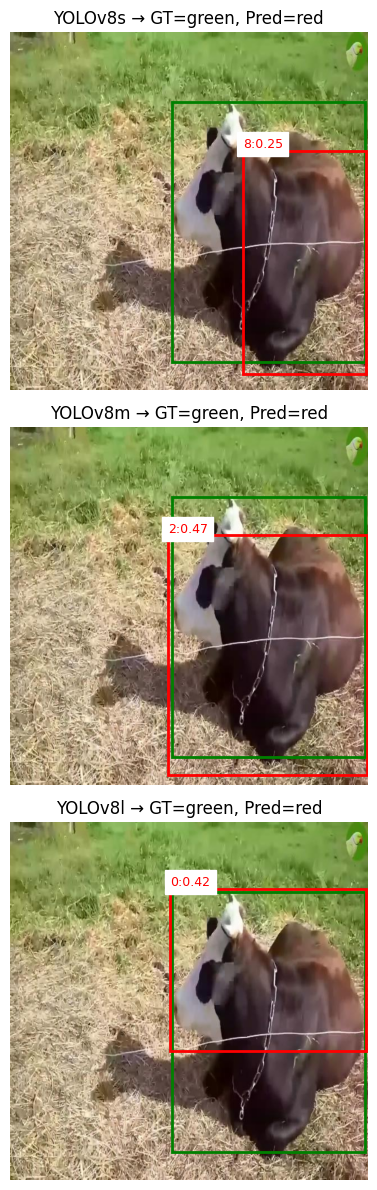

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2, pathlib, os

# helper: load YOLO format labels
def load_yolo_labels(lbl_path):
    boxes = []
    if not os.path.exists(lbl_path):
        return []
    with open(lbl_path, 'r') as fh:
        for line in fh:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            cls, xc, yc, w, h = parts
            boxes.append((int(float(cls)), float(xc), float(yc), float(w), float(h)))
    return boxes

# convert YOLO-format (cx,cy,w,h) -> pixel coords
def yolo_to_bbox(box, img_w, img_h):
    _, xc, yc, w, h = box
    x1 = int((xc - w/2) * img_w)
    y1 = int((yc - h/2) * img_h)
    x2 = int((xc + w/2) * img_w)
    y2 = int((yc + h/2) * img_h)
    return [x1, y1, x2, y2]

# plot GT + predictions
def plot_preds(models_dict, img_path, lbl_dir):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Ground truth boxes
    lbl_path = os.path.join(lbl_dir, pathlib.Path(img_path).stem + ".txt")
    gt_boxes = [yolo_to_bbox(b, w, h) for b in load_yolo_labels(lbl_path)]

    plt.figure(figsize=(16, 4 * len(models_dict)))
    for i, (name, model) in enumerate(models_dict.items()):
        preds = model.predict(img_path, imgsz=640, conf=0.25)[0]

        ax = plt.subplot(len(models_dict), 1, i+1)
        ax.imshow(img_rgb)

        # draw GT in green
        for x1, y1, x2, y2 in gt_boxes:
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1,
                                     linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

        # draw predictions in red
        for box in preds.boxes:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            rect = patches.Rectangle((int(x1), int(y1)), int(x2-x1), int(y2-y1),
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(int(x1), max(int(y1)-5,0), f"{cls}:{conf:.2f}",
                    color='r', fontsize=9, backgroundcolor='white')

        ax.set_title(f"{name} → GT=green, Pred=red")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Paths
val_img_dir = os.path.join(DATA_DIR, "images", "val")
val_lbl_dir = os.path.join(DATA_DIR, "labels", "val")
val_imgs = sorted(os.listdir(val_img_dir))[:3]  # pick a few validation images

# Run comparison
for fname in val_imgs:
    print(f"\nComparing predictions on: {fname}")
    img_path = os.path.join(val_img_dir, fname)
    plot_preds(loaded_models, img_path, val_lbl_dir)


In [24]:
import pandas as pd

metrics_results = {}

# Evaluate each model on your validation set
for name, model in loaded_models.items():
    print(f"\n Evaluating {name} ...")
    results = model.val(data=YAML_PATH, imgsz=640, conf=0.25)

    # collect main metrics
    metrics_results[name] = {
        "precision": results.results_dict.get("metrics/precision(B)", None),
        "recall": results.results_dict.get("metrics/recall(B)", None),
        "mAP50": results.results_dict.get("metrics/mAP50(B)", None),
        "mAP50-95": results.results_dict.get("metrics/mAP50-95(B)", None),
    }

# Put into DataFrame
df_metrics = pd.DataFrame(metrics_results).T
df_metrics = df_metrics.round(3)  # nicer formatting
print("\n Metrics Summary Across Models:")
display(df_metrics)

# Identify best model based on mAP50-95 (common ranking criterion)
best_model = df_metrics["mAP50-95"].idxmax()
best_score = df_metrics["mAP50-95"].max()
print(f"\n Best model is {best_model} with mAP50-95 = {best_score:.3f}")



 Evaluating YOLOv8s ...
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1870.4±672.3 MB/s, size: 61.9 KB)
val: Scanning /content/detection_workspace/data/labels/val.cache... 262 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 262/262 496.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 2.9it/s 5.9s
                   all        262        703      0.534      0.476      0.533      0.319
               class_0        120        467      0.824       0.79      0.869      0.673
               class_1          2          5      0.468        0.4      0.517      0.121
               class_2         48         59      0.845      0.678      0.773      0.503
               class_3          4          6      0.464      0.333      0.411      0.231
               class_4          9         10      0.292      0.662        0.6      0.362

precision  recall  mAP50  mAP50-95
YOLOv8s      0.534   0.476  0.533     0.319
YOLOv8m      0.640   0.428  0.494     0.306
YOLOv8l      0.200   0.264  0.228     0.149


 Best model is YOLOv8s with mAP50-95 = 0.319


## **Results**

| Model   | Precision | Recall | mAP50     | mAP50-95  |
| ------- | --------- | ------ | --------- | --------- |
| YOLOv8s | **0.534** | 0.476  | **0.533** | **0.319** |
| YOLOv8m | 0.640     | 0.428  | 0.494     | 0.306     |
| YOLOv8l | 0.200     | 0.264  | 0.228     | 0.149     |


1. **YOLOv8s achieved the best balance of speed and accuracy.**

2. Larger models (m, l) overfit or underperformed due to limited dataset size.

## **Conclusion**

1. The end-to-end pipeline successfully demonstrated object detection with YOLOv8.

2. Using YOLOv8 (CNN-based) models, we trained detectors that can localize and classify animals.

2. Dataset preparation was crucial — mismatched labels/images can break training.

3. Comparing models showed that bigger is not always better.

4. For this dataset, and the tested models, YOLOv8s was the best trade-off between accuracy and speed.

5. Key takeaway: Model performance depends not just on architecture but also on dataset quality, size, and compute resources.

7. The experiment shows the importance of model selection, dataset preparation, and evaluation in real-world deep learning tasks.

**Future improvements could include:**

1. Collecting more balanced data for under-represented classes.

2. Training for longer epochs with optimized hyperparameters.

3. Exploring other advanced detectors (e.g., Faster R-CNN, Detectron2).